In [1]:
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

# Einstein summation

In [2]:
import torch
from torch import tensor

In [3]:
m1 = torch.randn((2,3))
m1

tensor([[ 0.3693, -1.3040, -0.5833],
        [-0.6700,  0.2732, -0.8912]])

In [4]:
m2 = torch.randn((3,2))
m2

tensor([[-0.8730,  0.0364],
        [-2.2793, -0.2032],
        [ 0.2609, -2.0778]])

In [5]:
mr = torch.einsum('ik, kj->ikj', m1, m2)
mr

tensor([[[-0.3224,  0.0135],
         [ 2.9722,  0.2650],
         [-0.1522,  1.2121]],

        [[ 0.5849, -0.0244],
         [-0.6226, -0.0555],
         [-0.2325,  1.8517]]])

In [6]:
mr.sum(1)

tensor([[ 2.4976,  1.4905],
        [-0.2702,  1.7718]])

In [7]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [42]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False) # 避免打印浮点数时出现科学记数法

MultivariateNormal是用于定义多变量正态分布的类。它可以用来生成服从多变量正态分布的随机样本或计算概率密度函数


torch.diag函数的作用是从给定的一维张量（或列表）创建一个对角矩阵。对角矩阵是一个主对角线上元素非零，其余元素为零的方阵。

In [8]:
import torch
from torch.distributions import MultivariateNormal

# 定义均值向量和协方差矩阵
mean = torch.tensor([0.0, 0.0])
covariance_matrix = torch.tensor([[1.0, 0.5], [0.5, 2.0]])

# 创建MultivariateNormal对象
mvn = MultivariateNormal(mean, covariance_matrix)

# 生成随机样本
samples = mvn.sample()
print("Generated samples:", samples)

# 计算概率密度函数（PDF）
x = torch.tensor([0.5, 0.5])
pdf = mvn.log_prob(x)
print("PDF at x:", pdf)

Generated samples: tensor([-2.1019, -1.0658])
PDF at x: tensor(-2.2605)


In [9]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

In [10]:
n_clusters=6
n_samples=250

In [11]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ -8.7732,  -6.4394],
        [  4.0035,  -9.3117],
        [ 12.5480, -30.9798],
        [ -9.3783,  28.7658],
        [ -7.3034,  -2.8314],
        [-17.7347,  31.4571]])

In [12]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [13]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices) # torch.cat是PyTorch中的一个张量拼接函数，用于在给定维度上将多个张量连接起来。
data.shape

torch.Size([1500, 2])

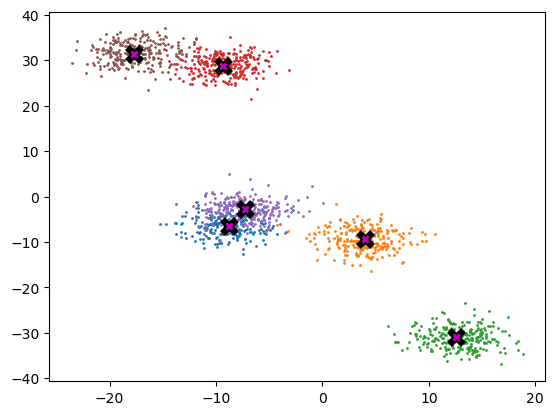

In [50]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)


plot_data(centroids, data, n_samples)

In [25]:
midp = data.mean(0)
midp

tensor([-4.4539,  1.8420])

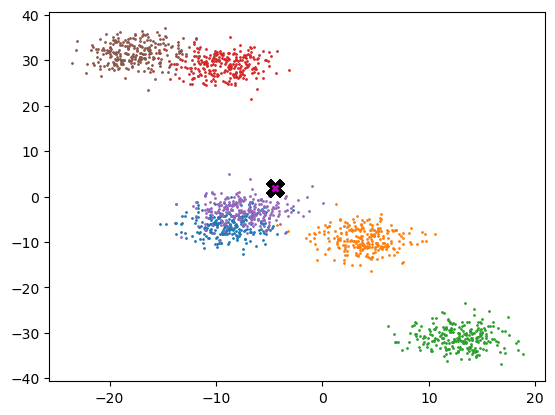

In [51]:
plot_data([midp]*6, data, n_samples)

In [29]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [32]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

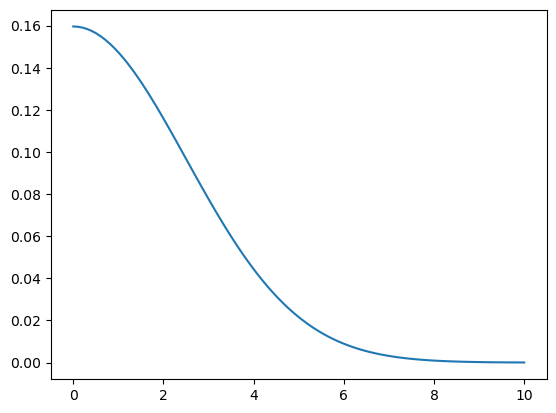

In [33]:
plot_func(partial(gaussian, bw=2.5))

In [34]:
X = data.clone()
x = data[0]

In [35]:
x

tensor([-6.5979, -1.3010])

In [36]:
x[None]

tensor([[-6.5979, -1.3010]])

In [37]:
(x-X)[:8]

tensor([[0.0000, 0.0000],
        [3.4160, 4.5388],
        [1.4392, 5.2130],
        [0.6703, 7.9389],
        [0.0376, 2.9850],
        [3.3461, 7.5184],
        [4.2670, 4.7015],
        [3.5695, 4.4828]])

欧式距离

In [38]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.0000, 5.6806, 5.4080, 7.9672, 2.9852, 8.2294, 6.3491, 5.7304])

In [41]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.012,     0.015,  ...,     0.000,     0.000,     0.000])

每一个点乘以对应的权重

In [53]:
weight[:, None]*X

tensor([[    -1.269,     -0.703],
        [    -0.096,     -0.053],
        [    -0.122,     -0.068],
        ...,
        [    -0.000,      0.000],
        [    -0.000,      0.000],
        [    -0.000,      0.000]])

In [44]:
def tri(d, i): return (-d+i).clamp_min(0)/i

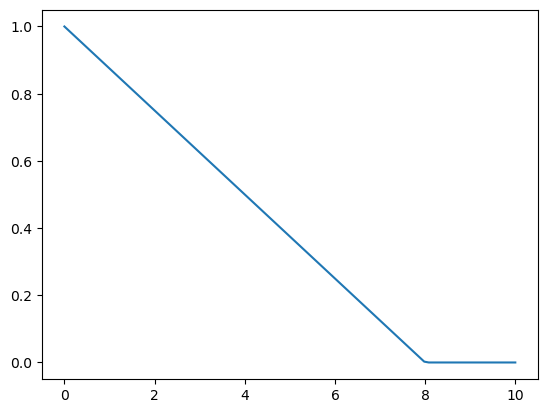

In [45]:
plot_func(partial(tri, i=8))

In [54]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:, None]*X).sum(0)/weight.sum()

In [55]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [56]:
%time X=meanshift(data)

CPU times: user 1.24 s, sys: 23.7 ms, total: 1.26 s
Wall time: 1.42 s


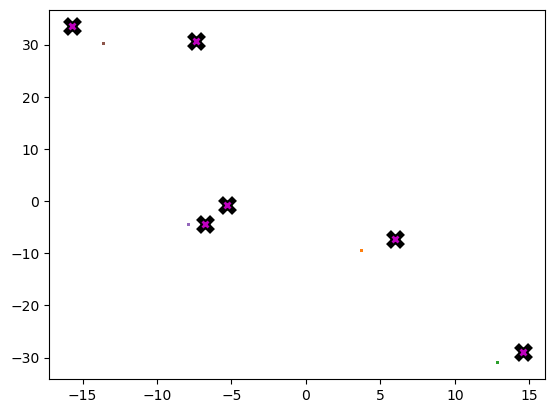

In [57]:
plot_data(centroids+2, X, n_samples)